In [1]:
from neo_access import *
from get_response_prop import *
#from get_response_prop import calculate_bandwidth,response_detection_core#,build_pdf
import numpy as np
import matplotlib.pyplot as plt
from neo.io import PickleIO
import pandas as pd
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import stats
import numpy.linalg as la
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from MUA_helper import (make_NP_array_from_linear_data, cleanAxes, placeAxesOnGrid,filter_detect,butter_bandpass,
                        butter_bandpass_filter,basic_peak_detector,get_prepare_PSTHs,plot_save,plot_save_single)

from scipy import stats
import pickle 
import pandas as pd
import scipy.io as sio
import os

In [193]:
## POM

roi_folder = r"F:\SNA-029958\processed"
probe = 2

rois_lower =sio.loadmat(os.path.join(roi_folder,'borders_lower_{}.mat'.format(probe)))['borders_lower']
rois_upper =sio.loadmat(os.path.join(roi_folder,'borders_upper_{}.mat'.format(probe)))['borders_upper']
rois_names =sio.loadmat(os.path.join(roi_folder,'borders_names_{}.mat'.format(probe)))['borders_names']

borders_lower = rois_lower.flatten().astype(int) -rois_lower.flatten().astype(int)[-1]
borders_upper = rois_upper.flatten().astype(int) -rois_upper.flatten().astype(int)[-1]

names = []
for i in range(borders_lower.size):
    names.append(rois_names[i][0][0])


border = int(376-borders_lower[10]/-10)
border2 = int(376-borders_lower[15]/-10)

structure='PoM'
exp_name = '20190809_probe2'
stim_name = '001_stimData_probe2.pkl'
metaData = '001_2019-08-09_11-30-04_sweepParameter'
working_dir = r"D:\Work\Recordings\DATA\Neuropixel\190809\2019-08-09_11-30-32"
stim_data_path =os.path.join(working_dir,'NationalInstruments',stim_name)
metaData_path =os.path.join(working_dir,'NationalInstruments',metaData)
color = 'lightblue'
border_regions = ['CORTEX','HIPP0CAMPUS','THALAMUS']

binsize = 0.2
samplingrate = 30000
sweeplength = 20 
pre = 9
n_ch = 384
trials = 25
duration = 2 
thresh=-5
ch_bin = 4

baselinestart = 7
baselineend = 9
stimulusstart = 9
stimulusend = 11

areas_PoM =np.array([[4,14],[14,41],[41,54],[54,70],[70,96]])
areas = areas_PoM

baselines = []
stimuli = []

colors = plt.cm.coolwarm(np.linspace(0,1,11))


In [163]:
## VPL

roi_folder = r"F:\SNA-035184\processed"
probe = 0

rois_lower =sio.loadmat(os.path.join(roi_folder,'borders_lower_{}.mat'.format(probe)))['borders_lower']
rois_upper =sio.loadmat(os.path.join(roi_folder,'borders_upper_{}.mat'.format(probe)))['borders_upper']
rois_names =sio.loadmat(os.path.join(roi_folder,'borders_names_{}.mat'.format(probe)))['borders_names']

borders_lower = rois_lower.flatten().astype(int) -rois_lower.flatten().astype(int)[-1]
borders_upper = rois_upper.flatten().astype(int) -rois_upper.flatten().astype(int)[-1]

names = []
for i in range(borders_lower.size):
    names.append(rois_names[i][0][0])


border = int(387-borders_lower[10]/-10)
border2 = int(387-borders_lower[16]/-10)

structure='VPL'
exp_name = '20190718_probe1'
stim_name = '002_stimData_probe1.pkl'
metaData = '002_2019-07-18_10-52-12_sweepParameter'
working_dir = r"D:\Work\Recordings\DATA\Neuropixel\190718\2019-07-18_10-52-01"
stim_data_path =os.path.join(working_dir,'NationalInstruments',stim_name)
metaData_path =os.path.join(working_dir,'NationalInstruments',metaData)
border_regions = ['CORTEX','D. THALAMUS','V. THALAMUS']

binsize = 0.250
samplingrate = 30000
sweeplength = 20 
ch_bin = 1
pre = 9
chs = 384
trials = 20
thresh = -5
duration=2
baselines = []
stimuli = []

baselinestart = 7
baselineend = 9
stimulusstart = 9
stimulusend = 11

save = True

areas_VPL =np.array([[0,20],[20,40],[40,60],[60,75],[int(95-20),95]])
areas = areas_VPL

colors = plt.cm.coolwarm(np.linspace(0,1,7))

In [164]:
def Gaussian_smooth(data, a):
    Gau_trial = 0*data 
    t_list = np.arange(data.shape[1])
    
    for i_neuron in range(data.shape[0]):
        for tau in range(data.shape[1]):
            g = np.exp(-a*(t_list-tau)**2)
            Sg = np.multiply(data[i_neuron,:], g)
            Gau_trial[i_neuron, tau] = np.sum(Sg)
            
    return Gau_trial 


def bin_data(data, bin_size):
    data = data.reshape(data.shape[0], -1, bin_size)
    data = np.sum(data, axis=2)
    return data 

In [194]:
with open(stim_data_path, 'rb') as f:
    x = pickle.load(f)   
try:
    timestamps = x["Stimstart"].values
except:
    timestamps = x['Timestamps'].dropna().values[::2]
    
data_corrected_list = []    
for i in range(len(timestamps))[:]:
        

    color = colors[i]
    folder = 'timestamps_{}'.format(i)
    folder_path  = working_dir + '/MUA-Analysis/' + exp_name + '/'+str(thresh) + '/timestamps_{}/'.format(i)
    stimulus = '{}_feedback'.format(i)

    files = os.listdir(folder_path)
    files = files[2:]
    #with open(stim_data_path, 'rb') as f:
    #   x = pickle.load(f)

    #feedback = x["Feedback"][stimulus]

    all_trials = {}
    for ch in range(n_ch):
        all_trials[str(ch)]= np.array([])
    print('dict created....')
    for trial in range(len(files)):
        test0 = np.load(os.path.join(folder_path,files[trial]))
        for ch in range(test0.shape[0]):
            all_trials[str(ch)] = np.sort(np.hstack((all_trials[str(ch)],test0[ch])))

    print('dict filled....')


    binwindow = binsize*samplingrate
    data = np.zeros([chs,int(sweeplength/binsize)-1])   
    bins = np.arange(0,sweeplength*samplingrate,binwindow)
    data_df = pd.DataFrame([])

    for x in range(chs):

        values,edges = np.histogram(all_trials[str(x)],bins)
        data[x,:] = values

    data_shape = np.reshape(data, (ch_bin,-1),order='F')
    data_db = np.mean(data_shape,axis =0)
    data_new = np.reshape(data_db,(int(chs/ch_bin),-1),order='F')
    
    
    for t in range(int(chs/ch_bin)):
        data_df[str(t)] = data_new[t,:]
    
    baseline_df = data_df.iloc[int(baselinestart/binsize):int(baselineend/binsize)]
    baseline_stats = baseline_df.describe().T
    data_corrected = pd.DataFrame([])
    baselines.append(baseline_stats)
    

    stimulus_df = data_df.iloc[int(stimulusstart/binsize):int(stimulusend/binsize)]
    stimulus_stats = stimulus_df.describe().T
    stimuli.append(stimulus_stats)

    for ii in range(int(chs/ch_bin)):

        data_corrected[str(ii)] = (data_df[str(ii)] - baseline_stats['mean'].iloc[ii])/baseline_stats['std'].iloc[ii]
    data_corrected_list.append(data_corrected)

dict created....
dict filled....
dict created....
dict filled....
dict created....
dict filled....
dict created....
dict filled....
dict created....
dict filled....
dict created....
dict filled....
dict created....
dict filled....
dict created....
dict filled....
dict created....
dict filled....
dict created....
dict filled....
dict created....
dict filled....


In [210]:
size = 32
areas = np.repeat(np.arange(0,385,size),2)[1:-1]
areas = np.reshape(areas, (int(areas.shape[0]/2),2))

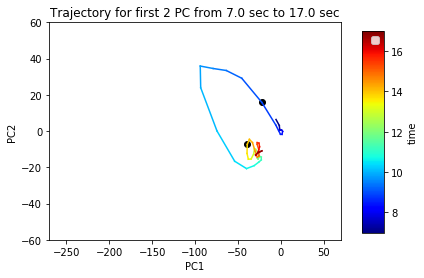

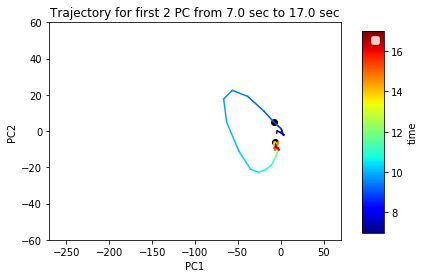

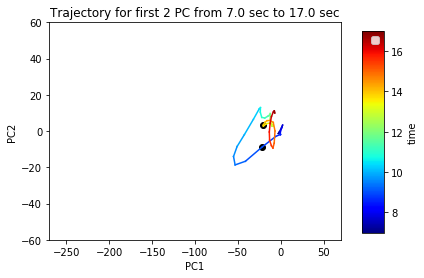

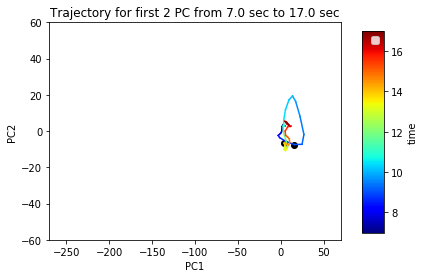

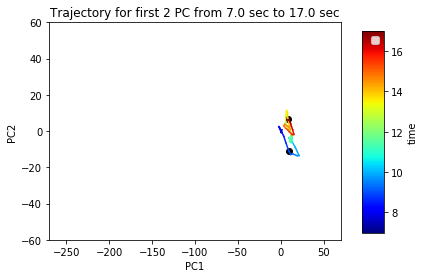

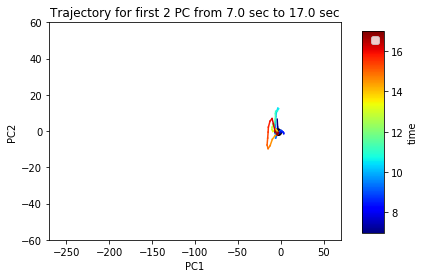

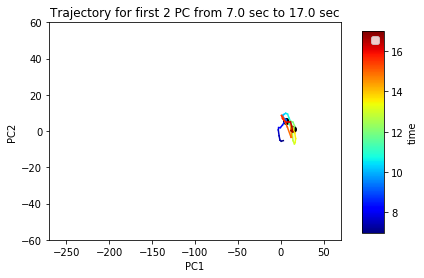

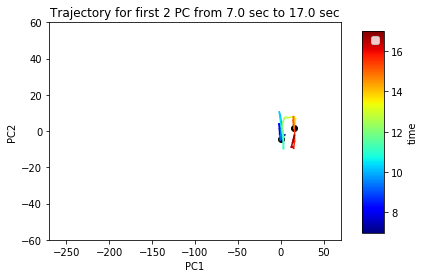

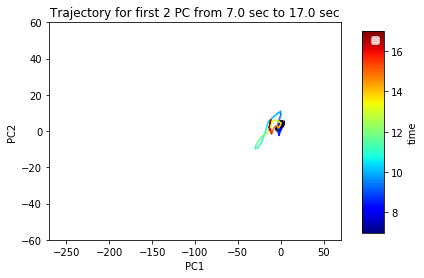

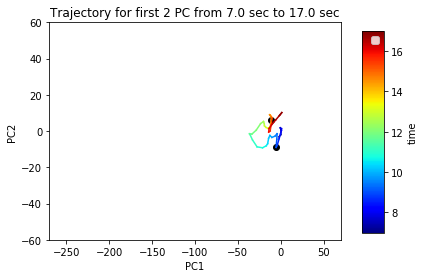

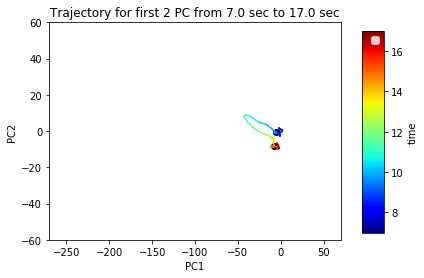

***************************


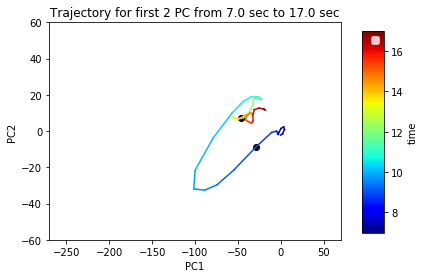

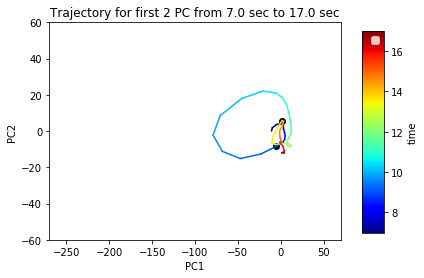

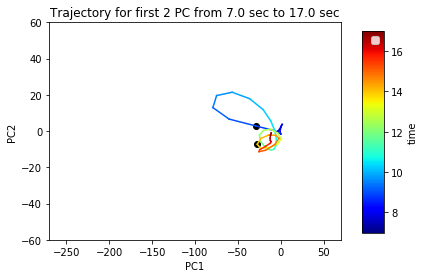

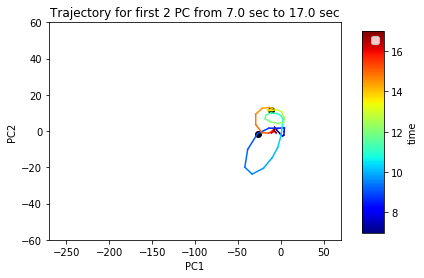

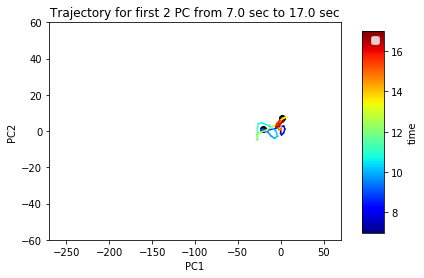

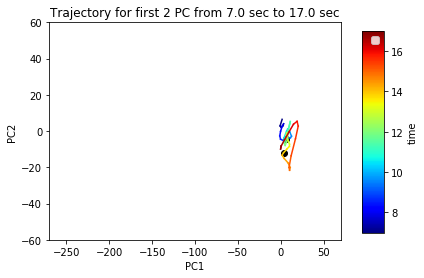

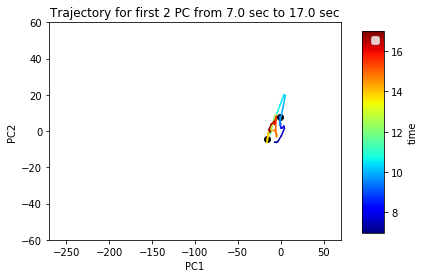

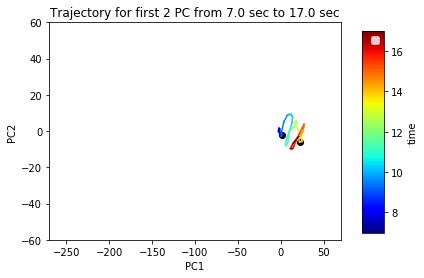

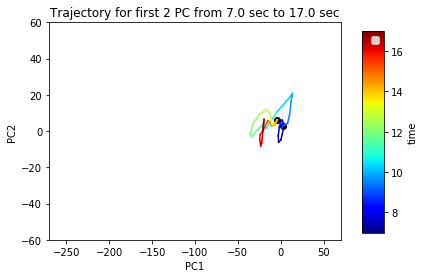

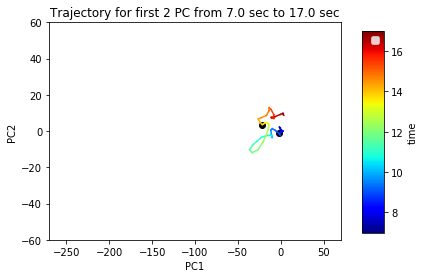

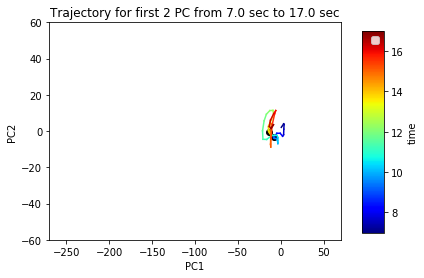

***************************


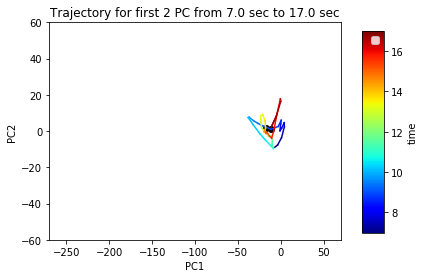

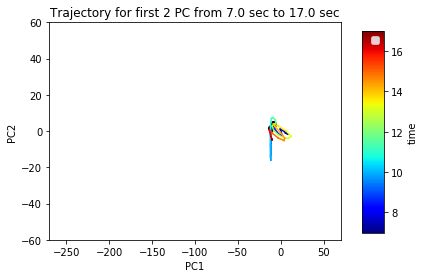

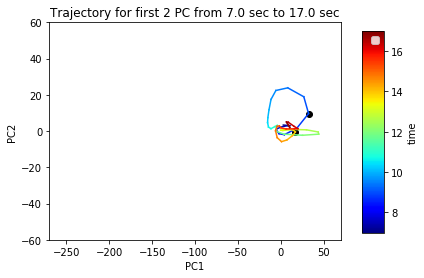

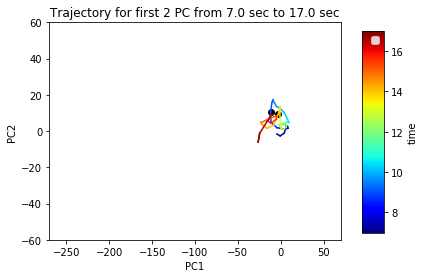

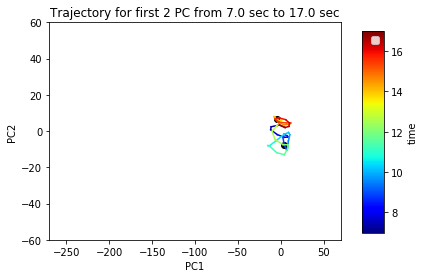

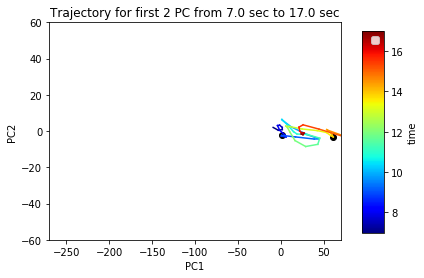

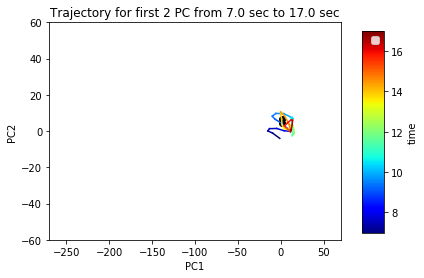

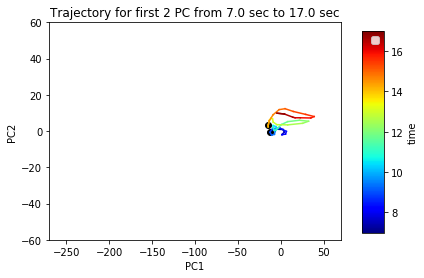

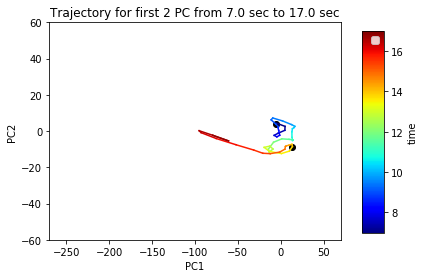

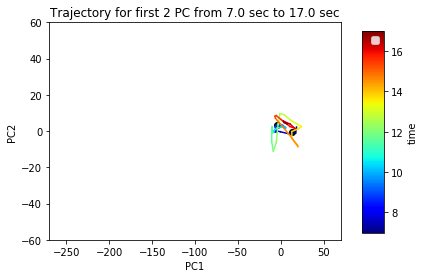

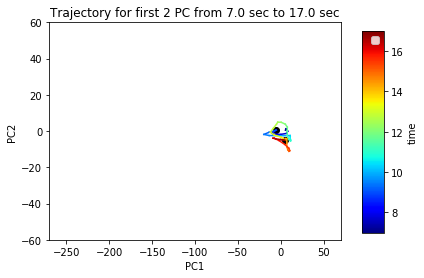

***************************


LinAlgError: Arrays cannot be empty

In [212]:
for ar in range(areas.shape[0]):

    pcs_tot = []

    for i in range(len(data_corrected_list)):

        data_corrected = data_corrected_list[i]

        data_tmp = data_corrected.T[(data_corrected.T.index.values.astype(int) > int(areas[ar][0]))&
                                                 (data_corrected.T.index.values.astype(int) < int(areas[ar][-1]))]

        Gau_trial = Gaussian_smooth(data_tmp.values, a=0.35)    

        u, s, vh = np.linalg.svd(Gau_trial, full_matrices=False)

        PC3 = np.zeros((3, data_tmp.shape[1]))
        for i in range(3):
            PC3[i,:] = vh[i,:]*s[i]
        pcs_tot.append(PC3)
    import matplotlib as mpl
    t_start = int((pre-2)/binsize)
    t_end = int((pre+duration+6)/binsize)
    
    t_stim = int(pre/binsize)
    t_stim_end = int(pre+duration/binsize)
    
    for inx in range(len(pcs_tot)):
        PC3 = pcs_tot[inx]

        x = PC3[0,t_start:t_end]
        y = PC3[1,t_start:t_end]
        
        #t_stim = t_stim-t_start
        #t_stim_end = t_stim_end - t_start

        n = len(x)

            # Your colouring array
        colors = plt.cm.jet(np.linspace(0,1,np.size(x)))
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cmap = mpl.cm.jet
        norm = mpl.colors.Normalize(vmin=t_start*binsize, vmax=t_end*binsize)

        """cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                        norm=norm,
                                        orientation='horizontal')"""

        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])

                # Segement plot and colour depending on T
        s = 1 # Segment length
        for i in range(0,n-s,s):
            ax.plot(x[i:i+s+1],y[i:i+s+1],color=colors[i])
        test =  ax.plot(x[i:i+s+1],y[i:i+s+1],color=colors[i])

        #ax.scatter(x[0], y[0], label='t={} sec'.format(t_stim), color=colors[0])
        #ax.scatter(x[-1], y[-1], label='t={} sec'.format(t_plateu), color=colors[len(colors)/2])
        #ax.scatter(x[-1], y[-1], label='t={} sec'.format(t_back), color=colors[-1])
        ax.scatter(x[int(t_stim-t_start)], y[int(t_stim-t_start)], label='t={} sec'.format(t_stim), color='black')
        ax.scatter(x[int(t_stim_end-t_start)], y[int(t_stim_end-t_start)], label='t={} sec'.format(t_stim), color='black')
       # ax.scatter(x[int(t_stim-t_start)], y[int(t_stim-t_start)], label='t={} sec'.format(t_stim), color=colors[int(t_stim-t_start)])
        ax.set_title('Trajectory for first 2 PC from {} sec to {} sec'.format(t_start*binsize,t_end*binsize))
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        plt.legend()
        ax.set_xlim(-270,70)
        ax.set_ylim(-60,60)
        #fig.colorbar(test, cax=cbar_ax)
        mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap,
                                    norm=norm,
                                    orientation='vertical',label='time')

    plt.show()
    print('***************************')

In [184]:
t_stim

-48

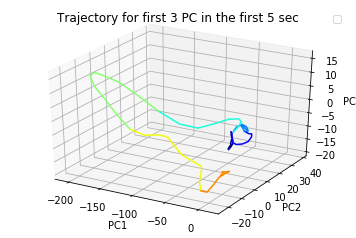

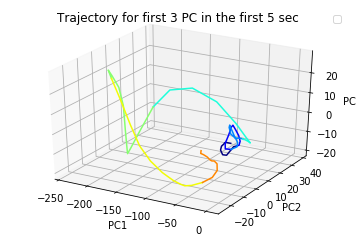

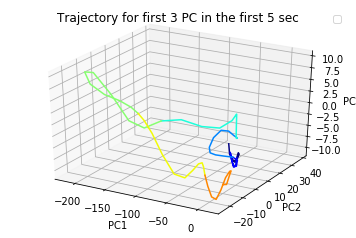

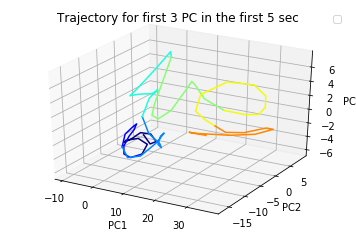

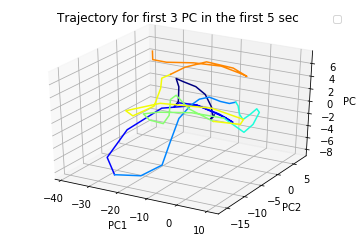

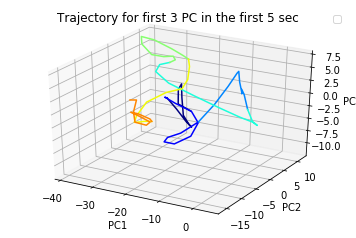

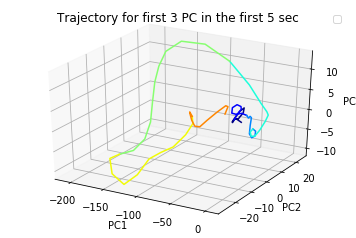

In [159]:
from mpl_toolkits.mplot3d import Axes3D
t_start = 0
t_end = int(20/binsize)

for inx in range(len(pcs_tot)):
    PC3 = pcs_tot[inx]
    
    x = PC3[0,t_start:t_end]
    y = PC3[1,t_start:t_end]
    z = PC3[2,t_start:t_end]


    n = len(x)

        # Your colouring array
    colors = plt.cm.jet(np.linspace(0,1,np.size(x)))
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    s = 10 # Segment length
    n = len(x)
    for i in range(0,n-s,s):
        ax.plot(x[i:i+s+1], y[i:i+s+1], z[i:i+s+1], color=colors[i])
    
    plt.legend()

    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.set_title('Trajectory for first 3 PC in the first 5 sec')
    plt.show()

In [ ]:
plot_all_PC(data_zscored, t_end=2199)

In [ ]:
def Gaussian_smooth(data, a):
    Gau_trial = 0*data 
    t_list = np.arange(data.shape[1])
    
    for i_neuron in range(data.shape[0]):
        for tau in range(data.shape[1]):
            g = np.exp(-a*(t_list-tau)**2)
            Sg = np.multiply(data[i_neuron,:], g)
            Gau_trial[i_neuron, tau] = np.sum(Sg)
            
    return Gau_trial 


In [ ]:
Gau_trial = Gaussian_smooth(data_zscored, a=0.05)



In [ ]:
plot_all_PC(Gau_trial, t_end=2199)